In [16]:
%load_ext autoreload
%autoreload 2

import polars as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing script for the ICPF dataset

We first load the data using Polars and then perform some basic filtering.

In [17]:
# We first load the data using Polars
with pl.StringCache():
    df_growth_raw = pl.read_parquet("./data/raw/icpf-level2_growth.parquet")
    df_plots_raw = pl.read_parquet("./data/raw/icpf-level2_plot-info.parquet")
    df_crown_raw = pl.read_parquet("./data/raw/icpf-level2_crown-conditions.parquet")
    df_deposition_raw = pl.read_parquet("./data/raw/icpf-level2_depositions.parquet")
    df_soil_raw = pl.read_parquet("./data/raw/icpf-level2_soil-solutions.parquet")

In [18]:
print(f"Initial number of rows: {df_growth_raw.height}")

# Drop all rows with null values in the 'diameter' column
df_growth = df_growth_raw.drop_nulls(subset="diameter")
print(f" `- after dropping nulls: {df_growth.height}")

# Drop all rows where country is 'Belgium' or 'Spain'
df_growth = df_growth.filter(~pl.col("country").is_in(["Belgium", "Spain"]))
print(f" `- after dropping Belgium and Spain: {df_growth.height}")

# Drop all rows with:
# - diameter_quality_code is larger than 2 (implausible, https://icp-forests.org/documentation/Dictionaries/d_gr_quality_code.html)
# - or diameter_method_code is in [7] (estimated diameter, https://icp-forests.org/documentation/Dictionaries/d_diameter.html)
# - or removal_code is larger than 10 (dead tree, see https://icp-forests.org/documentation/Dictionaries/d_removal_mortality_ccgr.html)
# Keep null values in 'diameter_quality_code', 'diameter_method_code', and 'removal_code' for now

df_growth = df_growth.filter(
    pl.col("diameter_quality_code").is_null() | ~pl.col("diameter_quality_code").gt(2)
)
df_growth = df_growth.filter(
    pl.col("diameter_method_code").is_null()
    | ~pl.col("diameter_method_code").is_in([7])
)
df_growth = df_growth.filter(
    pl.col("removal_code").is_null() | ~pl.col("removal_code").gt(10)
)

print(f" `- after dropping quality codes 3-9: {df_growth.height}")

# Drop rows with negative or zero diameter values
df_growth = df_growth.filter(pl.col("diameter").gt(0))
print(f" `- after dropping negative diameters: {df_growth.height}")

# Compute the growth rate and relative growth rate between two censuses
df_growth = (
    df_growth.sort(by=["country_code", "plot_code", "tree_number", "date"])
    .with_columns(
        period_start=pl.col("date")
        .shift(1)
        .over("country", "plot_code", "tree_number"),
        period_end=pl.col("date"),
        diameter_start=pl.col("diameter")
        .shift(1)
        .over("country", "plot_code", "tree_number"),
        diameter_end=pl.col("diameter"),
        diameter_method_code_start=pl.col("diameter_method_code")
        .shift(1)
        .over("country", "plot_code", "tree_number"),
        diameter_method_code_end=pl.col("diameter_method_code"),
    )
    .with_columns(
        period_duration=pl.col("period_end") - pl.col("period_start"),
        growth=pl.col("diameter_end") - pl.col("diameter_start"),
    )
    .with_columns(
        period_duration_d=pl.col("period_duration").dt.total_days(),
        period_duration_y=pl.col("period_duration").dt.total_days() / 365.25,
    )
    .with_columns(
        growth_rate=pl.col("growth") / pl.col("period_duration_y"),
        growth_rel=pl.col("growth") / pl.col("diameter_start"),
    )
    .with_columns(
        growth_rate_rel=pl.col("growth_rel") / pl.col("period_duration_y"),
    )
    .select(
        "survey_year",
        "tree_id",
        "plot_id",
        "country_code",
        "country",
        "tree_species_code",
        "specie",
        "plot_code",
        "tree_number",
        "period_start",
        "period_end",
        "diameter_start",
        "diameter_end",
        "period_duration_d",
        "period_duration_y",
        "growth",
        "growth_rate",
        "growth_rel",
        "growth_rate_rel",
        "diameter_method_code_start",
        "diameter_method_code_end",
        pl.col("removal_code").alias("removal_code_end"),
        pl.col("diameter_quality").alias("diameter_quality_end"),
        pl.col("diameter_method").alias("diameter_method_end"),
        pl.col("removal_info").alias("removal_info_end"),
    )
    .drop_nulls(subset=["period_duration_y"])
)
print(f" `- after computing growth rates: {df_growth.height}")

# Keep only growth periods between 4 and 6 years included
df_growth = df_growth.filter(pl.col("period_duration_y").is_between(4.0, 6.0))
print(f" `- after filtering growth periods between 4 and 6 years: {df_growth.height}")

# Keep only relative growth rates between 0 and 0.1 to avoid dead trees and implausible growth rates
df_growth = df_growth.filter(pl.col("growth_rate_rel").is_between(0, 0.1))
print(
    f" `- after filtering relative growth rates between 0 and 0.1: {df_growth.height}"
)

Initial number of rows: 626456
 `- after dropping nulls: 605159
 `- after dropping Belgium and Spain: 549800
 `- after dropping quality codes 3-9: 525010
 `- after dropping negative diameters: 524956
 `- after computing growth rates: 280967
 `- after filtering growth periods between 4 and 6 years: 150278
 `- after filtering relative growth rates between 0 and 0.1: 142926


We then add plot information such as latitude/longitude, slope, orientation and altitude to each tree record.

In [19]:
# Join to plot information
PLOT_COLS = [
    "plot_latitude",
    "plot_longitude",
    "plot_slope",
    "plot_orientation",
    "plot_altitude",
]

df_growth = df_growth.join(
    df_plots_raw.select("plot_id", *PLOT_COLS),
    on="plot_id",
    how="left",
)

print(f"Number of rows after joining with plot information: {df_growth.height}")

Number of rows after joining with plot information: 142926


We then add the crown condition and social status to each record. Those are recorded at a different granularity (annually or biannually), so we compute statistics across the census period for each tree record.

In [20]:
# Prepare the crown condition data
print(f"Number of rows in crown condition data: {df_crown_raw.height}")

# Dropping all rows with null or negative defoliation
df_crown = df_crown_raw.filter(
    pl.col("defoliation").is_not_null() & pl.col("defoliation").ge(0)
).with_columns(defoliation=pl.col("defoliation").cast(pl.Int32))
print(f"Number of rows with valid defoliation: {df_crown.height}")

# Merge the crown condition data with the growth data
df_crown = (
    df_crown.sort(by="date")
    .join_asof(
        df_growth.select(
            pl.col("period_end").alias("date"),
            "tree_id",
            "period_start",
            "period_end",
            "specie",
        ).sort(by="date"),
        by=["tree_id", "specie"],
        on="date",
        strategy="forward",
        suffix="_gp",
    )
    .filter(pl.col("date").is_between(pl.col("period_start"), pl.col("period_end")))
    .drop_nulls(subset="period_end")
)
print(f"Number of rows after merging crown condition data: {df_crown.height}")

df_crown = df_crown.group_by("tree_id", "period_start", "period_end", "specie").agg(
    pl.len().alias("num_defoliation_obs"),
    # Defoliation statistics
    pl.mean("defoliation").alias("defoliation_mean"),
    pl.min("defoliation").alias("defoliation_min"),
    pl.max("defoliation").alias("defoliation_max"),
    pl.median("defoliation").alias("defoliation_median"),
    pl.last("defoliation").alias("defoliation_last"),
    # Social status statistics
    pl.min("social_class_code").alias("social_class_min"),
    pl.max("social_class_code").alias("social_class_max"),
    pl.col("social_class_code").mode().first().alias("social_class_mode"),
    pl.last("social_class_code").alias("social_class_last"),
    # Dominance indicators
    pl.col("social_class_code").eq(1).any().alias("was_dominant"),
    pl.col("social_class_code").eq(2).any().alias("was_codominant"),
    pl.col("social_class_code").eq(3).any().alias("was_subdominant"),
    pl.col("social_class_code").eq(4).any().alias("was_suppressed"),
    pl.col("social_class_code").eq(5).any().alias("was_dying"),
)
print(f"Number of rows after aggregating crown condition data: {df_crown.height}")

# Drop rows where defoliation reached 100% (dead trees)
df_crown = df_crown.filter(pl.col("defoliation_max").lt(100))
print(f"Number of rows after dropping dead trees: {df_crown.height}")

# Drop rows with less than two defoliation observations
df_crown = df_crown.filter(pl.col("num_defoliation_obs").gt(1))
print(
    f"Number of rows after dropping trees with less than two observations: {df_crown.height}"
)

Number of rows in crown condition data: 800207
Number of rows with valid defoliation: 740311
Number of rows after merging crown condition data: 171905
Number of rows after aggregating crown condition data: 42688
Number of rows after dropping dead trees: 42502
Number of rows after dropping trees with less than two observations: 39922


In [21]:
# Merge back to the growth data
df_growth_all = df_growth.join(
    df_crown,
    on=["tree_id", "period_start", "period_end", "specie"],
    how="left",
).drop_nulls(subset="num_defoliation_obs")

print(f"Number of rows after merging crown condition data: {df_growth_all.height}")

Number of rows after merging crown condition data: 39922


In [22]:
# Summarize the number of trees and growth periods per species
species_summary = (
    df_growth_all.filter(
        pl.col("specie").is_in(
            [
                "Picea abies",
                "Pinus sylvestris",
                "Fagus sylvatica",
                "Quercus petraea",
                "Quercus robur",
            ]
        )
    )
    .group_by("specie")
    .agg(
        pl.col("tree_id").n_unique().alias("num_trees"),
        pl.len().alias("num_growth_periods"),
    )
    .sort(by="num_growth_periods", descending=True)
)

species_summary.head()

specie,num_trees,num_growth_periods
cat,u32,u32
"""Picea abies""",7833,14455
"""Pinus sylvestris""",5515,9298
"""Fagus sylvatica""",3726,7101
"""Quercus petraea""",717,1570
"""Quercus robur""",562,1026


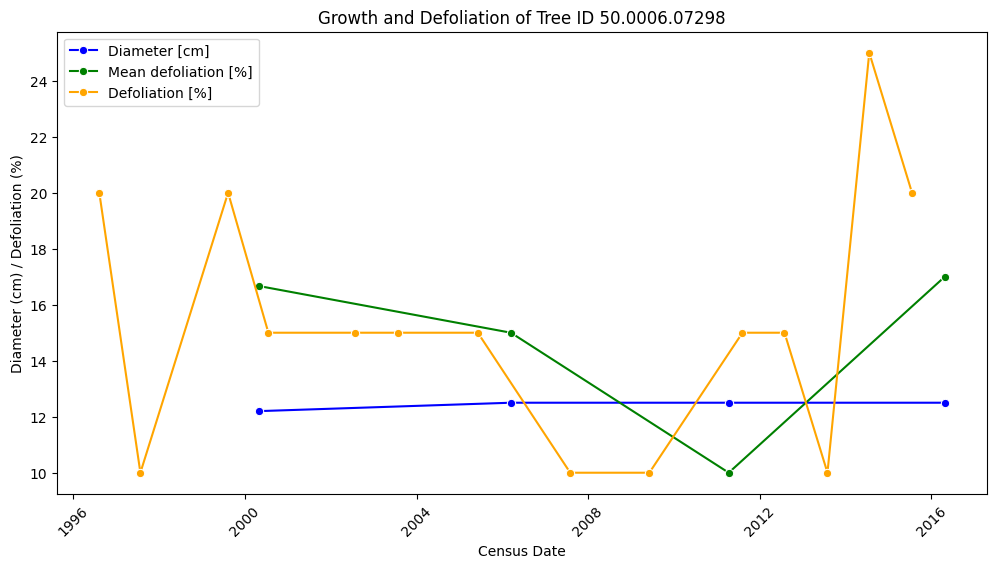

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_tree_with_defoliation(
    df_crown_raw: pl.DataFrame, df_growth: pl.DataFrame, tree_id: str
) -> None:
    """Plot defoliation and growth for a specific tree.

    Args:
        tree_id (str): The ID of the tree to plot.
    """
    df_crown_raw = df_crown_raw.filter(pl.col("tree_id") == tree_id)
    df_growth = df_growth.filter(pl.col("tree_id") == tree_id)

    if df_crown.is_empty() or df_growth.is_empty():
        raise ValueError(f"No data available for tree {tree_id}.")

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_growth.to_pandas(),
        x="period_end",
        y="diameter_end",
        marker="o",
        label="Diameter [cm]",
        color="blue",
    )
    sns.lineplot(
        data=df_growth.to_pandas(),
        x="period_end",
        y="defoliation_mean",
        marker="o",
        label="Mean defoliation [%]",
        color="green",
    )
    sns.lineplot(
        data=df_crown_raw.to_pandas(),
        x="date",
        y="defoliation",
        marker="o",
        label="Defoliation [%]",
        color="orange",
    )
    plt.title(f"Growth and Defoliation of Tree ID {tree_id}")
    plt.xlabel("Census Date")
    plt.ylabel("Diameter (cm) / Defoliation (%)")
    plt.xticks(rotation=45)
    plt.legend()


tree_id = "50.0006.07298"
plot_tree_with_defoliation(df_crown_raw, df_growth_all, tree_id)

## Join depositions and soil solutions  

Here we join the deposition and soil solution data to the tree records. x

In [24]:
import polars.selectors as cs

print(f"Number of rows in deposition data {df_deposition_raw.height}")

# Drop rows without census dates
df_deposition = df_deposition_raw.filter(
    pl.col("date_start").is_not_null() | pl.col("date_end").is_not_null()
)
print(f" `- after dropping rows without census dates: {df_deposition.height}")

# Drop rows with sampling codes that indicate abnormal sampling
df_deposition = df_deposition.filter(~pl.col("vsampling_code").is_in([2, 3, 4, 7, 9]))
print(f" `- after dropping abnormal sampling: {df_deposition.height}")

# Drop sampler code with value 8 (not a tree sample)
df_deposition = df_deposition.filter(~pl.col("sampler_code").eq(8))
print(f" `- after dropping sampler code 8: {df_deposition.height}")

# Replace -1.0 values with nulls in all columns starting with 'dep_'
df_deposition = df_deposition.with_columns(
    pl.when(cs.starts_with("dep_").exclude("dep_alk").ne(-1.0))
    .then(cs.starts_with("dep_").exclude("dep_alk"))
    .otherwise(None)
)

df_deposition = df_deposition.group_by("plot_id", "survey_year").agg(
    cs.starts_with("dep_").mean(),
    # cs.starts_with("dep_").std().name.suffix("_std"),
    pl.len().alias("num_deposition_obs"),
)

Number of rows in deposition data 429223
 `- after dropping rows without census dates: 423035
 `- after dropping abnormal sampling: 387708
 `- after dropping sampler code 8: 387088


In [25]:
# Join with growth data
df_deposition = (
    df_deposition.join(
        df_growth_all.select(
            "period_start",
            "period_end",
            "tree_id",
            "plot_id",
            "specie",
        ),
        on="plot_id",
        how="inner",
    )
    .with_columns(
        period_start_year=pl.col("period_start").dt.year(),
        period_end_year=pl.col("period_end").dt.year(),
    )
    .filter(
        pl.col("survey_year").is_between(
            pl.col("period_start_year"), pl.col("period_end_year")
        )
    )
    .group_by("tree_id", "period_start", "period_end")
    .agg(
        cs.starts_with("dep_").mean(),
        pl.sum("num_deposition_obs").alias("num_deposition_obs"),
    )
)

print(
    f"Number of rows after joining deposition data with growth data: {df_deposition.height}"
)


# Join back to growth data
df_growth_all = df_growth_all.join(
    df_deposition.select(
        "tree_id",
        "period_start",
        "period_end",
        "num_deposition_obs",
        "dep_ph",
        "dep_cond",
        "dep_k",
        "dep_ca",
        "dep_mg",
        "dep_na",
        "dep_n_nh4",
        "dep_cl",
        "dep_n_no3",
        "dep_s_so4",
        "dep_alk",
        "dep_n_tot",
        "dep_doc",
        "dep_al",
        "dep_mn",
        "dep_fe",
        "dep_p_po4",
        "dep_cu",
        "dep_zn",
        "dep_hg",
        "dep_pb",
        "dep_co",
        "dep_mo",
        "dep_ni",
        "dep_cd",
        "dep_s_tot",
        "dep_c_tot",
        "dep_n_org",
        "dep_p_tot",
        "dep_cr",
        "dep_n_no2",
        "dep_hco3",
        "dep_don",
    ),
    on=["tree_id", "period_start", "period_end"],
    how="left",
).with_columns(num_deposition_obs=pl.col("num_deposition_obs").fill_null(0))

print(f"Number of rows with at le: {df_growth_all.height}")

df_growth_all.head(15)

Number of rows after joining deposition data with growth data: 35881
Number of rows with at le: 39922


survey_year,tree_id,plot_id,country_code,country,tree_species_code,specie,plot_code,tree_number,period_start,period_end,diameter_start,diameter_end,period_duration_d,period_duration_y,growth,growth_rate,growth_rel,growth_rate_rel,diameter_method_code_start,diameter_method_code_end,removal_code_end,diameter_quality_end,diameter_method_end,removal_info_end,plot_latitude,plot_longitude,plot_slope,plot_orientation,plot_altitude,num_defoliation_obs,defoliation_mean,defoliation_min,defoliation_max,defoliation_median,defoliation_last,social_class_min,…,was_subdominant,was_suppressed,was_dying,num_deposition_obs,dep_ph,dep_cond,dep_k,dep_ca,dep_mg,dep_na,dep_n_nh4,dep_cl,dep_n_no3,dep_s_so4,dep_alk,dep_n_tot,dep_doc,dep_al,dep_mn,dep_fe,dep_p_po4,dep_cu,dep_zn,dep_hg,dep_pb,dep_co,dep_mo,dep_ni,dep_cd,dep_s_tot,dep_c_tot,dep_n_org,dep_p_tot,dep_cr,dep_n_no2,dep_hco3,dep_don
i64,str,str,i64,cat,i64,cat,i64,str,datetime[ns],datetime[ns],f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,cat,cat,cat,i64,i64,i64,cat,f64,u32,f64,i32,i32,f64,i32,i64,…,bool,bool,bool,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2000,"""01.0017.00001""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""1""",1996-11-07 00:00:00,2000-11-27 00:00:00,37.2,39.2,1481,4.054757,2.0,0.493248,0.053763,0.013259,null,null,null,null,null,null,473400,11500,0,"""Flat""",125.0,4,18.75,15,25,17.5,15,2,…,false,false,false,130,5.7825,29.546218,1.837598,1.34516,0.279763,1.030654,0.812344,2.212808,0.588524,0.82834,41.451131,1.528333,NaN,0.022501,0.274009,0.016998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,"""01.0017.00010""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""10""",1996-11-07 00:00:00,2000-11-27 00:00:00,32.9,34.7,1481,4.054757,1.8,0.443923,0.054711,0.013493,null,null,null,null,null,null,473400,11500,0,"""Flat""",125.0,4,16.25,15,20,15.0,15,2,…,true,false,false,130,5.7825,29.546218,1.837598,1.34516,0.279763,1.030654,0.812344,2.212808,0.588524,0.82834,41.451131,1.528333,NaN,0.022501,0.274009,0.016998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,"""01.0017.00011""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""11""",1996-11-07 00:00:00,2000-11-27 00:00:00,40.9,42.7,1481,4.054757,1.8,0.443923,0.04401,0.010854,null,null,null,null,null,null,473400,11500,0,"""Flat""",125.0,4,18.75,15,25,17.5,15,2,…,false,false,false,130,5.7825,29.546218,1.837598,1.34516,0.279763,1.030654,0.812344,2.212808,0.588524,0.82834,41.451131,1.528333,NaN,0.022501,0.274009,0.016998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,"""01.0017.00012""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""12""",1996-11-07 00:00:00,2000-11-27 00:00:00,36.8,39.6,1481,4.054757,2.8,0.690547,0.076087,0.018765,null,null,null,null,null,null,473400,11500,0,"""Flat""",125.0,4,17.5,15,20,17.5,20,2,…,true,false,false,130,5.7825,29.546218,1.837598,1.34516,0.279763,1.030654,0.812344,2.212808,0.588524,0.82834,41.451131,1.528333,NaN,0.022501,0.274009,0.016998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,"""01.0017.00013""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""13""",1996-11-07 00:00:00,2000-11-27 00:00:00,32.0,33.6,1481,4.054757,1.6,0.394598,0.05,0.012331,null,null,null,null,null,null,473400,11500,0,"""Flat""",125.0,4,16.25,15,20,15.0,15,2,…,true,false,false,130,5.7825,29.546218,1.837598,1.34516,0.279763,1.030654,0.812344,2.212808,0.588524,0.82834,41.451131,1.528333,NaN,0.022501,0.274009,0.016998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2000,"""01.0017.00019""","""01.0017""",1,"""France""",48,"""Quercus petraea""",17,"""19""",1996-11-07 00:00:00,2000-11-27 00:00:00,40.1,42.2,1481,4.054757,2.

Now do the same for soil solutions.

In [26]:
print("Number of rows in raw soil solutions data:", df_soil_raw.height)

# Drop rows with null or negative values of sample_vol
df_soil = (
    df_soil_raw.filter(pl.col("sample_vol").is_null() | pl.col("sample_vol").gt(0))
    # Replace invalid values in soil solutions data
    .with_columns(
        pl.when(cs.starts_with("ss_").is_between(0.0001, 10000))
        .then(cs.starts_with("ss_"))
        .otherwise(None)
    )
    .group_by("plot_id", "survey_year")
    .agg(
        pl.mean("sample_vol").alias("sample_vol"),
        cs.starts_with("ss_").mean().name.keep(),
        pl.len().alias("num_soil_obs"),
    )
    .select(
        "plot_id",
        "survey_year",
        "sample_vol",
        "num_soil_obs",
        "ss_ph",
        "ss_cond",
        "ss_k",
        "ss_ca",
        "ss_mg",
        "ss_n_no3",
        "ss_s_so4",
        "ss_alk",
        "ss_al",
        "ss_doc",
        "ss_na",
        "ss_n_nh4",
        "ss_cl",
        "ss_n_tot",
        "ss_fe",
        "ss_mn",
        "ss_al_labile",
        "ss_p",
        "ss_cr",
        "ss_ni",
        "ss_zn",
        "ss_cu",
        "ss_pb",
        "ss_cd",
        "ss_si",
    )
)


df_soil = (
    df_soil.join(
        df_growth_all.select(
            "plot_id",
            "tree_id",
            "period_start",
            "period_end",
        ),
        on="plot_id",
        how="inner",
    )
    .with_columns(
        period_start_year=pl.col("period_start").dt.year(),
        period_end_year=pl.col("period_end").dt.year(),
    )
    .filter(
        pl.col("survey_year").is_between(
            pl.col("period_start_year"), pl.col("period_end_year")
        )
    )
    .group_by("tree_id", "period_start", "period_end")
    .agg(
        cs.starts_with("ss_").mean(),
        pl.sum("num_soil_obs").alias("num_soil_obs"),
    )
    .select(
        "tree_id", "period_start", "period_end", "num_soil_obs", cs.starts_with("ss_")
    )
)

df_growth_all = df_growth_all.join(
    df_soil,
    on=["tree_id", "period_start", "period_end"],
    how="left",
)

print("Number of rows after merging soil solutions data:", df_growth_all.height)

Number of rows in raw soil solutions data: 312170
Number of rows after merging soil solutions data: 39922


In [40]:
# Add plot metadata from Etzold et al. (2023)
df_plot_meta = (
    pl.read_csv("./data/raw/ICP-Forests-Plots_Meta.csv")
    .with_columns(
        plot_id=pl.col("plotid")
        .cast(pl.Utf8)
        .replace("NA", None)  # Replace 'NA' with None
    )
    .drop_nulls(subset="plot_id")
    .with_columns(
        plot_id=pl.col("plot_id").str.slice(0, 2)
        + "."
        + pl.col("plot_id").str.slice(2),
        yr_first=pl.col("yr_first").replace("NA", None).cast(pl.Int32),
        yr_last=pl.col("yr_last").replace("NA", None).cast(pl.Int32),
        sdi=pl.col("sdi").replace("NA", None).cast(pl.Float32),
        age=pl.col("age").replace("NA", None).cast(pl.Float32),
        temp=pl.col("temp").replace("NA", None).cast(pl.Float32),
        precip=pl.col("precip").replace("NA", None).cast(pl.Float32),
    )
    .drop_nulls(subset=["yr_first", "yr_last"])
    .group_by("plot_id")
    .agg(
        pl.mean("sdi").alias("soph_avg_sdi"),
        pl.mean("age").alias("soph_avg_age"),
        pl.mean("temp").alias("soph_avg_temp"),
        pl.mean("precip").alias("soph_avg_precip"),
    )
)

df_growth_all = df_growth_all.join(
    df_plot_meta,
    on="plot_id",
    how="left",
)

In [41]:
print("Number of rows in total:", df_growth_all.height)
height = df_growth_all.filter(
    pl.any_horizontal(cs.starts_with("dep_").is_not_null())
).height
print("Number of rows with defoliation data:", height)
height = df_growth_all.filter(
    pl.any_horizontal(cs.starts_with("ss_").is_not_null())
).height
print("Number of rows with soil solution data:", height)

Number of rows in total: 39922
Number of rows with defoliation data: 35881
Number of rows with soil solution data: 23039


In [42]:
from config import DATA_PATH
import os

df_growth_all.write_parquet(
    os.path.join(DATA_PATH, "tidy", "cpf-level2_cleaned.parquet")
)

In [43]:
pl.read_parquet(
    os.path.join(DATA_PATH, "tidy", "cpf-level2_growth-periods_with-cc.parquet")
).shape

(39946, 103)

In [44]:
pl.read_parquet(os.path.join(DATA_PATH, "tidy", "cpf-level2_cleaned.parquet")).shape

(39922, 118)